## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os

In [ ]:
# Directory to the project folder
deep_learning_dir = '/content/gdrive/My Drive/BMI 707 Project' 

In [ ]:
train = pd.read_csv(deep_learning_dir + '/data_formatting/training_data.tsv', sep = '\t')
test = pd.read_csv(deep_learning_dir + '/data_formatting/testing_data.tsv', sep = '\t')
val = pd.read_csv(deep_learning_dir + '/data_formatting/validation_data.tsv', sep = '\t')

In [ ]:
merged_df = train
merged_df = merged_df.append(test, ignore_index = True)
merged_df = merged_df.append(val, ignore_index = True)

merged_df[merged_df['criteria'].apply(lambda x: not isinstance(x, float))]

## Generating embeddings

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.1 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 895 kB 77.3 MB/s 
     |████████████████████████████████| 6.6 MB 68.8 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import pickle 
from tqdm import tqdm

device = torch.device("cuda:0")

In [ ]:
class ClinBiobertEmbedding(object):
  '''
  Embedding class adapted from BiobertEmbedding class. 
  Incorporates ability to initialise with own tokenizer and model, and adapted sentence encoding. 

  Example usage: 
    clinBiobertEmbedding = ClinBiobertEmbedding(myTokenizer, myModel)
    embedding = ClinBiobertEmbedding.sentence_encoding(myTextToEmbed)

  '''
  def __init__(self, tokenizer, model):
    '''
    Initialiser. Sets tokenizer and model of object.
    '''
    self.tokenizer = tokenizer
    self.model = model.to(device)

  def process_text(self, text):
    '''
    Process text with tokenizer. 
    Generally not directly used by user.
    '''
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = self.tokenizer.tokenize(marked_text)
    return tokenized_text

  def sentence_encoding(self,text):
    '''
    Encodes sentence using tokenizer and model.

    Input: 
      text (str): sentence (without tokenizer marks) to encode. 

    Output: 
      sentence_embedding (tensor): tensor with embedding of sentence.
    '''
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = self.tokenizer.tokenize(marked_text)

    # Mark each of the tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    # Predict hidden states features for each layer
    bert_output = self.model(tokens_tensor, segments_tensors)
    token_vecs = bert_output['last_hidden_state'][0]

    # Calculate the average of token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    return sentence_embedding.detach().cpu().numpy() #this returns the embedding as a copy in cpu memory as np array

In [ ]:
def get_all_protocols():
	'''
	Method for getting all protocols
	'''
	protocols = merged_df['criteria'].tolist()
	return protocols

def clean_protocol(protocol):
	'''
	Method for cleaning protocols, to be used in split_protocol
	'''
	if isinstance(protocol, float):
		protocol = "No criteria"
	protocol = protocol.lower()
	protocol_split = protocol.split('\n')
	filter_out_empty_fn = lambda x: len(x.strip())>0
	strip_fn = lambda x:x.strip()
	protocol_split = list(filter(filter_out_empty_fn, protocol_split))	
	protocol_split = list(map(strip_fn, protocol_split))
	return protocol_split 

def split_protocol(protocol):
	'''
	Method for splitting protocols
	'''
	protocol_split = clean_protocol(protocol)
	inclusion_idx, exclusion_idx = len(protocol_split), len(protocol_split)	
	for idx, sentence in enumerate(protocol_split):
		if "inclusion" in sentence:
			inclusion_idx = idx
			break
	for idx, sentence in enumerate(protocol_split):
		if "exclusion" in sentence:
			exclusion_idx = idx 
			break 		
	if inclusion_idx + 1 < exclusion_idx + 1 < len(protocol_split):
		inclusion_criteria = protocol_split[inclusion_idx:exclusion_idx]
		exclusion_criteria = protocol_split[exclusion_idx:]
		if not (len(inclusion_criteria) > 0 and len(exclusion_criteria) > 0):
			print(len(inclusion_criteria), len(exclusion_criteria), len(protocol_split))
			exit()
		return inclusion_criteria, exclusion_criteria ## list, list 
	else:
		return protocol_split

In [ ]:
def get_embedder():
  '''
  Retrieving the clinical bio BERT embedder
  '''
  clinbert_tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
  clinbert_model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
  clinbert_model.trainable = False
  clinbert_embedder = ClinBiobertEmbedding(clinbert_tokenizer, clinbert_model)
  return clinbert_embedder

In [ ]:
def collect_cleaned_sentence_set():
	'''
	Obtaining a set of all possible sentences used in the data.
	'''
	protocol_lst = get_all_protocols() 
	cleaned_sentence_lst = []
	for protocol in protocol_lst:
		result = split_protocol(protocol)
		cleaned_sentence_lst.extend(result[0])
		if len(result)==2:
			cleaned_sentence_lst.extend(result[1])
	return list(set(cleaned_sentence_lst))

In [ ]:
cleaned_sentence_set = collect_cleaned_sentence_set() 
clinbert_embedder = get_embedder()

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Splitting into chunks

In [ ]:
chunks_dir = deep_learning_dir + "/embedding/criteria_sentence_embeddings/chunks"

In [ ]:
def save_sentence_bert_dict_pkl_chunk(clinbert_embedder, sentence_iterator, i, size):
  protocol_sentence_2_embedding = dict()
  for sentence in tqdm(sentence_iterator,desc=f"generating for {i}"):
    protocol_sentence_2_embedding[sentence] = clinbert_embedder.sentence_encoding(sentence)
  pickle.dump(protocol_sentence_2_embedding, open(f'{chunks_dir}/sentence2embedding_{i}.pkl', 'wb'))
  return protocol_sentence_2_embedding

In [ ]:
import os
import gc
def generate_datasets(size):
    return (cleaned_sentence_set[i:i+size] for i in range(0, len(cleaned_sentence_set), size))

SIZE = 10000
dirpath = chunks_dir
if not os.path.exists(dirpath):
  os.makedirs(dirpath)
total_len = len(cleaned_sentence_set)
for i, dataset in enumerate(generate_datasets(10000)):
  save_sentence_bert_dict_pkl_chunk(clinbert_embedder, dataset,i,SIZE)
  gc.collect()

generating for 29: 100%|██████████| 6346/6346 [01:26<00:00, 72.98it/s]


In [ ]:
#combining all files
full_pickle_dict = {}
for i in range(29):
  with open(f"{chunks_dir}/sentence2embedding_{i}.pkl","rb") as f:
    pickle_dict = pickle.load(f)
    full_pickle_dict.update(pickle_dict)
  
pickle.dump(full_pickle_dict, open(f'{deep_learning_dir}/embeddings/criteria_sentence_embeddings/sentence2embedding_full.pkl', 'wb'))

## Loading any embedding

I have now generated a dictionary for each possible sentence to embedding. The reason for this is that this will speed up time (rather than calculating the embeddings on the fly). 

With load_sentence_2_vec I can now load up that dictionary. This is then a dictionary of 'some split sentence' = (np version of) tensor.

Then, I can take a 'raw' protocol in protocol2feature, split it in incl and excl, and for each sentence in incl/excl can get the sentence embedding. Then, I create the full embedding of the criteria from the sentences. I do this by truncating or padding. The number of sentences I allow is 32, this is based on the distribution of lengths of the training set.

In [ ]:
def load_sentence_2_vec():
	'''
	Loading the sentence2vec dictionary.
	'''
	sentence2vec = pickle.load(open(f'{deep_learning_dir}/embeddings/criteria_sentence_embeddings/sentence2embedding_full.pkl', 'rb'))
	return sentence2vec 

In [ ]:
def reshape_features(feature, size):
  '''
  Reshaping feature size

  Input: 
    feature (tensor): tensor of torch.Size([x])
    size (int): maximum length

  Output: 
    feature (tensor): tensor of torch.Size([size])
  '''
  if feature.shape[0] > size:
    feature = feature[0:size]
  else: 
    b = torch.zeros(size - feature.shape[0])
    feature = torch.cat((feature, b))
  return feature

In [ ]:
def protocol2feature(protocol, sentence2vec, size):
  '''
  Extracting inclusion and exclusion feature from a protocol.

  Input: 
    protocol (str): criteria text
    sentence2vec (dict): sentence to embedding dictionary
    size (int): size of output tensor (to pad or truncate concatenated sentence embeddings with)

  Output: 
    inclusion_feature (tensor): tensor of torch.Size([size]) with inclusion criteria embedding
    exclusion_feature (tensor): tensor of torch.Size([size]) with exclusion criteria embedding
  '''
  # same lengths (24576)
  result = split_protocol(protocol)
  inclusion_criteria = result[0]
  if len(result) > 1:
    exclusion_criteria = result[1]
  else: 
    exclusion_criteria = []

  inclusion_feature = [torch.from_numpy(sentence2vec[sentence]) for sentence in inclusion_criteria if sentence in sentence2vec]
  exclusion_feature = [torch.from_numpy(sentence2vec[sentence]) for sentence in exclusion_criteria if sentence in sentence2vec]

  if inclusion_feature == []:
    inclusion_feature = torch.zeros(size)
  else:
    inclusion_feature = torch.cat(inclusion_feature, 0)
    inclusion_feature = reshape_features(inclusion_feature, size)

  if exclusion_feature == []:
    exclusion_feature = torch.zeros(size)
  else:
    exclusion_feature = torch.cat(exclusion_feature, 0)
    exclusion_feature = reshape_features(exclusion_feature, size)

  return inclusion_feature, exclusion_feature 

In [ ]:
max_length = 24576 #32 * 768

In [ ]:
sentence2vec = load_sentence_2_vec()

In [ ]:
df_temp = merged_df[['nctid', 'criteria']]
dict_crit = df_temp.set_index('nctid').T.to_dict('list')

nctid2incl_criteria = dict()
nctid2excl_criteria = dict()

max_size = 24576

for key, value in dict_crit.items(): 
  incl, excl = protocol2feature(value[0], sentence2vec, max_size)
  nctid2incl_criteria[key] = incl
  nctid2excl_criteria[key] = excl

In [ ]:
pickle.dump(nctid2incl_criteria, open(f'{deep_learning_dir}/embeddings/nctid2incl_criteria.pkl', 'wb'))
pickle.dump(nctid2excl_criteria, open(f'{deep_learning_dir}/embeddings/nctid2excl_criteria.pkl', 'wb'))

## Determination of max length

In [ ]:
train_df_temp = train[['nctid', 'criteria']]
train_dict_crit = train_df_temp.set_index('nctid').T.to_dict('list')

train_nctid2incl_criteria = dict()
train_nctid2excl_criteria = dict()


for key, value in train_dict_crit.items(): 
  incl, excl = protocol2feature(value[0], sentence2vec)
  train_nctid2incl_criteria[key] = incl
  train_nctid2excl_criteria[key] = excl

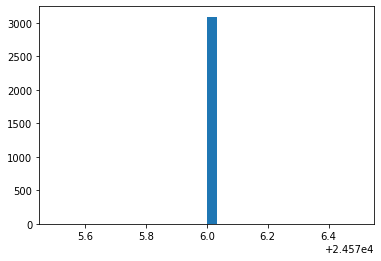

In [ ]:
import matplotlib.pyplot as plt

leng = []

for key, value in train_nctid2excl_criteria.items(): 
  leng_temp = value.shape[0]
  leng.append(leng_temp)

plt.hist(leng, bins = 30)
plt.show()

### Lengths of criterias

In [ ]:
df_temp = merged_df[['nctid', 'criteria']]
dict_crit = df_temp.set_index('nctid').T.to_dict('list')

len_nctid2incl_criteria = dict()
len_nctid2excl_criteria = dict()

max_size = 24576

for key, value in dict_crit.items(): 

  result = split_protocol(value[0])
  inclusion_criteria = result[0]
  if len(result) > 1:
    exclusion_criteria = result[1]
  else: 
    exclusion_criteria = []

  leng_incl = len(inclusion_criteria)
  leng_excl = len(exclusion_criteria)


  len_nctid2incl_criteria[key] = leng_incl
  len_nctid2excl_criteria[key] = leng_excl

In [ ]:
pickle.dump(len_nctid2incl_criteria, open(f'{deep_learning_dir}/embeddings/length_nctid2incl_criteria.pkl', 'wb'))
pickle.dump(len_nctid2excl_criteria, open(f'{deep_learning_dir}/embeddings/length_nctid2excl_criteria.pkl', 'wb'))